In [1]:
import os
# Local Imports
from src.seg2map import map_interface
from src.seg2map import log_maker #must be the first module loaded to create logs folder
i
# External Imports
import ee
from google.auth import exceptions as google_auth_exceptions

# suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Authenticate and Initialize with Google Earth Engine (GEE)

- Run this cell to initialize with GEE which will allow you to download remote sensing data from GEE.

### First Time Users

- In order to use Google Earth Engine (GEE) you will need to sign up to request access to use Google Earth Engine.https://signup.earthengine.google.com. You will only need to do this once and it takes only a day to get your account verified.

### How `ee.Authenticate()` works

- In order to initialize with GEE you will need an authorization token with is obtained by running `ee.Authenticate()`.This token lasts 7 days and during those 7 days you will not need to authenticate with google earth engine with an access code. Once the 7 days are up you will need to reauthenticate to use GEE again.


In [2]:
try:
    ee.Initialize()
except google_auth_exceptions.RefreshError as exception:
    print("Please authenticate with Google:\n")
    ee.Authenticate()
    ee.Initialize()

# How to Use The Map

---
1.  Click `Save Settings` Button
1. Use the rectangle tool to draw a bounding box along the coastline.
2. Click `Generate ROI` to create ROI rectangles along the coastline in the bounding box. This may take some time.
- You should see a coastline appear in yellow and some rectangles along it.
3. Load transects into your bounding box with the `Load Transects` button. If any exist for the bounding box you selected they should appear.
4. Click the ROIs you want to download.
5. Once you've selected all the ROIs you want to download click `Downlod Imagery`
 - If any of the ROIs succesfully download they will have their own folder with all their data in the `data` directory in the `CoastSeg` directory
6. To extract a timeseries of shorelines for the ROIs you downloaded click `Extract Shorelines`
7. If any shorelines were extracted you can compute the cross distances along the transects and shoreline by clicking `Compute Transects` and save the output to a json file in the roi directory
8. If any shorelines were extracted you can compute the cross distances along the transects and shoreline by clicking `Save Transects CSV`  and save the output to a csv in the roi directory

In [2]:
# from coastseg.map_UI import UI
from src.seg2map.map_UI import UI
from src.seg2map.map_interface import CoastSeg_Map

coastsegmap=CoastSeg_Map()
coastseg_ui = UI(coastsegmap)
coastseg_ui.create_dashboard()

HBox()

HBox()

In [ ]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl

watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

m = Map(layers=(watercolor, ), center=(50, 354), zoom=5)

draw_control = DrawControl()
draw_control.polyline =  {
    "shapeOptions": {
        "color": "#6bc2e5",
        "weight": 8,
        "opacity": 1.0
    }
}
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 1.0
    },
    "drawError": {
        "color": "#dd253b",
        "message": "Oups!"
    },
    "allowIntersection": False
}
draw_control.circle = {
    "shapeOptions": {
        "fillColor": "#efed69",
        "color": "#efed69",
        "fillOpacity": 1.0
    }
}
draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 1.0
    }
}

m.add_control(draw_control)

m

In [6]:
print(coastsegmap.map.find_layer('ROI'))

GeoJSON(data={'type': 'FeatureCollection', 'features': [{'id': '0', 'type': 'Feature', 'properties': {'id': '1', 'style': {'color': '#555555', 'fill_color': '#555555', 'fillOpacity': 0.1, 'weight': 1}}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-124.166621, 40.871052], [-124.166621, 40.894933], [-124.142247, 40.894933], [-124.142247, 40.871052], [-124.166621, 40.871052]]]}}, {'id': '1', 'type': 'Feature', 'properties': {'id': '2', 'style': {'color': '#555555', 'fill_color': '#555555', 'fillOpacity': 0.1, 'weight': 1}}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-124.164718, 40.951685], [-124.164718, 41.016997], [-124.028772, 41.016997], [-124.028772, 40.951685], [-124.164718, 40.951685]]]}}, {'id': '2', 'type': 'Feature', 'properties': {'id': '3', 'style': {'color': '#555555', 'fill_color': '#555555', 'fillOpacity': 0.1, 'weight': 1}}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-124.286932, 40.667917], [-124.286932, 40.853075], [-124.057609, 40.853075], [-124.0576

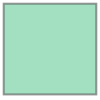

In [13]:
coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="1"]["geometry"][0]

In [78]:
df = coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="1"].bounds.drop(index=0)


In [163]:
coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"].bounds

,minx,miny,maxx,maxy
1,-124.164718,40.951685,-124.028772,41.016997


<AxesSubplot: >

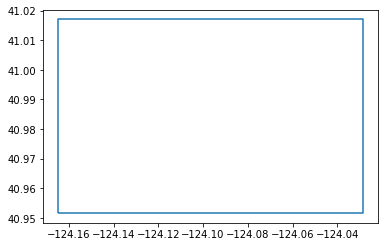

In [162]:
coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"].boundary.plot()


<AxesSubplot: >

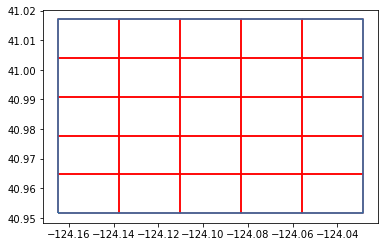

In [177]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiPolygon, Polygon
from shapely.ops import split
def splitPolygon(polygon, nx, ny):
    minx, miny, maxx, maxy = polygon.bounds.iloc[0]
    dx = (maxx - minx) / nx  # width of a small part
    dy = (maxy - miny) / ny  # height of a small part
    horizontal_splitters = [LineString([(minx, miny + i*dy), (maxx, miny + i*dy)]) for i in range(ny)]
    vertical_splitters = [LineString([(minx + i*dx, miny), (minx + i*dx, maxy)]) for i in range(nx)]
    splitters = horizontal_splitters + vertical_splitters
    result = polygon["geometry"].iloc[0]
    for splitter in splitters:
        result = MultiPolygon(split(result, splitter))
    return result

# polygon = coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"]["geometry"].iloc[0]
polygon = coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"]
myPolygons = splitPolygon(polygon, 5, 5)
import geopandas as gpd
gdfR   = gpd.GeoDataFrame(columns=['geometry'], data=myPolygons.geoms)
f,ax=plt.subplots()
gdfR.boundary.plot(ax=ax, color='red')
polygon.boundary.plot(ax=ax)

In [182]:
coastsegmap.rois.gdf['geometry'].bounds

,minx,miny,maxx,maxy
0,-124.166621,40.871052,-124.142247,40.894933
1,-124.164718,40.951685,-124.028772,41.016997
2,-124.286932,40.667917,-124.057609,40.853075
3,-124.477806,40.531320,-124.263588,40.662709
4,-124.282512,41.020147,-123.919989,41.276609


In [175]:
polygon = coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"]
minx, miny, maxx, maxy = polygon.bounds.iloc[0]
minx, miny, maxx, maxy

(-124.164718, 40.951685, -124.028772, 41.016997)

In [173]:
polygon.bounds.iloc[0]

minx   -124.164718
miny     40.951685
maxx   -124.028772
maxy     41.016997
Name: 1, dtype: float64

In [174]:
polygon.bounds.iloc[0][0]

-124.164718

In [124]:
d=coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"].bounds.to_dict()
d

{'minx': {1: -124.164718},
 'miny': {1: 40.951685},
 'maxx': {1: -124.028772},
 'maxy': {1: 41.016997}}

In [97]:
for k,v in d.items():
    # keyz=v.keys()
    print(list(v.values())[0])
    # print((list(keyz))[0])
    # print(v[(list(keyz))[0]])

-124.164718
40.951685
-124.028772
41.016997


In [106]:
minx=list(d['minx'].values())[0]
miny=list(d['miny'].values())[0]
maxx=list(d['maxx'].values())[0]
maxy=list(d['maxy'].values())[0]
minx, miny, maxx, maxy

(-124.164718, 40.951685, -124.028772, 41.016997)

In [116]:
from shapely.geometry import LineString, MultiPolygon, Polygon

dx = (maxx - minx) / num_splitters  # width of a small part
dy = (maxy - miny) / num_splitters  # height of a small part
horizontal_splitters = [
    LineString([(minx, miny + i * dy), (maxx, miny + i * dy)])
    for i in range(num_splitters)
]
vertical_splitters = [
    LineString([(minx + i * dx, miny), (minx + i * dx, maxy)])
    for i in range(num_splitters)
]

In [117]:
horizontal_splitters

[<LINESTRING (-124.165 40.952, -124.029 40.952)>,
 <LINESTRING (-124.165 40.973, -124.029 40.973)>,
 <LINESTRING (-124.165 40.995, -124.029 40.995)>]

In [120]:
vertical_splitters

[<LINESTRING (-124.165 40.952, -124.165 41.017)>,
 <LINESTRING (-124.119 40.952, -124.119 41.017)>,
 <LINESTRING (-124.074 40.952, -124.074 41.017)>]

In [135]:
splitters = horizontal_splitters + vertical_splitters
splitters

[<LINESTRING (-124.165 40.952, -124.029 40.952)>,
 <LINESTRING (-124.165 40.973, -124.029 40.973)>,
 <LINESTRING (-124.165 40.995, -124.029 40.995)>,
 <LINESTRING (-124.165 40.952, -124.165 41.017)>,
 <LINESTRING (-124.119 40.952, -124.119 41.017)>,
 <LINESTRING (-124.074 40.952, -124.074 41.017)>]

In [190]:
coastsegmap.rois.gdf.area

0    0.000582
1    0.008879
2    0.042461
3    0.028146
4    0.092973
dtype: float64

In [202]:
area(json.loads(coastsegmap.rois.gdf.to_json())['features'][1]['geometry'])

83058642.38999565

In [191]:
coastsegmap.rois.gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [187]:
coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"]["geometry"].iloc[0].area

0.00887890515200013

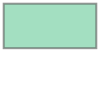

In [129]:
coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"]["geometry"].iloc[0]

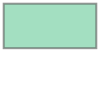

In [157]:
polygon = coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"]["geometry"].iloc[0]
polygon

In [134]:
from shapely.ops import split
result = polygon
for splitter in splitters:
    result = MultiPolygon(split(result, splitter))
parts = [list(part.exterior.coords) for part in result.geoms]

print("Number of individual tiles: {}".format(len(parts)))

Number of individual tiles: 9


In [136]:
for part in parts:
    print(part)

[(-124.164718, 40.951685), (-124.164718, 40.973455666666666), (-124.11940266666666, 40.973455666666666), (-124.11940266666666, 40.951685), (-124.164718, 40.951685)]
[(-124.11940266666666, 40.973455666666666), (-124.07408733333334, 40.973455666666666), (-124.07408733333334, 40.951685), (-124.11940266666666, 40.951685), (-124.11940266666666, 40.973455666666666)]
[(-124.07408733333334, 40.973455666666666), (-124.028772, 40.973455666666666), (-124.028772, 40.951685), (-124.07408733333334, 40.951685), (-124.07408733333334, 40.973455666666666)]
[(-124.164718, 40.973455666666666), (-124.164718, 40.995226333333335), (-124.11940266666666, 40.995226333333335), (-124.11940266666666, 40.973455666666666), (-124.164718, 40.973455666666666)]
[(-124.11940266666666, 40.995226333333335), (-124.07408733333334, 40.995226333333335), (-124.07408733333334, 40.973455666666666), (-124.11940266666666, 40.973455666666666), (-124.11940266666666, 40.995226333333335)]
[(-124.07408733333334, 40.995226333333335), (-1

In [145]:
gee_collection = "USDA/NAIP/DOQQ"
collection = ee.ImageCollection(gee_collection)
collection

In [146]:
polys = ee.Geometry.Polygon(parts[0])
polys

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -124.164718,
              40.951685
            ],
            [
              -124.164718,
              40.973455666666666
            ],
            [
              -124.11940266666666,
              40.973455666666666
            ],
            [
              -124.11940266666666,
              40.951685
            ],
            [
              -124.164718,
              40.951685
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [141]:
centroid = polys.centroid()
centroid

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Geometry.centroid",
    "arguments": {
      "geometry": {
        "functionInvocationValue": {
          "functionName": "GeometryConstructors.Polygon",
          "arguments": {
            "coordinates": {
              "constantValue": [
                [
                  [
                    -124.164718,
                    40.951685
                  ],
                  [
                    -124.164718,
                    40.973455666666666
                  ],
                  [
                    -124.11940266666666,
                    40.973455666666666
                  ],
                  [
                    -124.11940266666666,
                    40.951685
                  ],
                  [
                    -124.164718,
                    40.951685
                  ]
                ]
              ]
            },
            "evenOdd": {
              "constantValue": true
            

In [143]:
lng, lat = centroid.getInfo()["coordinates"]
lng, lat

(-124.14206033334014, 40.96257195266582)

In [149]:
year="2009"
start_date = year + "-01-01"
end_date = year + "-12-31"
collection = collection.filterBounds(polys)
collection = collection.filterDate(start_date, end_date).sort(
            "system:time_start", True
)
count = collection.size().getInfo()
count

2

In [152]:
img_lst = collection.toList(1000)
# print(img_lst)

In [155]:
N = []
for i in range(0, count):
    image = ee.Image(img_lst.get(i))
    name = image.get("system:index").getInfo()
    N.append(name)
    print(name)

m_4012407_ne_10_1_20090622
m_4012408_nw_10_1_20090622


In [156]:
for n in N:
    image = ee.Image("USDA/NAIP/DOQQ/" + n)
    geemap.ee_export_image(
                    image,
                    os.getcwd()
                    + os.sep
                    + site
                    + os.sep
                    + "feature"
                    + str(featurenumber)
                    + os.sep
                    + year
                    + os.sep
                    + "chunk"
                    + str(counter)
                    + os.sep
                    + "chunk"
                    + str(counter)
                    + "_"
                    + n
                    + ".tif",
                    scale=OUT_RES_M,
                    region=polys,
                    file_per_band=True,
                    crs="EPSG:4326",
    )

NameError: name 'geemap' is not defined

In [115]:
from shapely.geometry import LineString, MultiPolygon, Polygon
horizontal_splitters = [
            LineString([(minx, miny + i * dy), (maxx, miny + i * dy)])
            for i in range(ny)
        ]

NameError: name 'ny' is not defined

In [98]:
# minx miny maxx maxy
bounds = [list(v.values())[0] for v in d.values()]
bounds 

[-124.164718, 40.951685, -124.028772, 41.016997]

In [108]:
# dir(coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"].bounds

In [55]:
geodata = coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="2"].to_json()
geodata

'{"type": "FeatureCollection", "features": [{"id": "1", "type": "Feature", "properties": {"id": "2"}, "geometry": {"type": "Polygon", "coordinates": [[[-124.164718, 40.951685], [-124.164718, 41.016997], [-124.028772, 41.016997], [-124.028772, 40.951685], [-124.164718, 40.951685]]]}}]}'

In [56]:
rect = json.loads(geodata)
rect

{'type': 'FeatureCollection',
 'features': [{'id': '1',
   'type': 'Feature',
   'properties': {'id': '2'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-124.164718, 40.951685],
      [-124.164718, 41.016997],
      [-124.028772, 41.016997],
      [-124.028772, 40.951685],
      [-124.164718, 40.951685]]]}}]}

In [49]:
rect['features'][0]['geometry']

{'type': 'Polygon',
 'coordinates': [[[-124.166621, 40.871052],
   [-124.166621, 40.894933],
   [-124.142247, 40.894933],
   [-124.142247, 40.871052],
   [-124.166621, 40.871052]]]}

In [16]:
print(type(coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="1"]["geometry"][0]))

<class 'shapely.geometry.polygon.Polygon'>


In [207]:
coastsegmap.rois.gdf

,geometry,id
0,"POLYGON ((-124.16662 40.87105, -124.16662 40.8...",1
1,"POLYGON ((-124.16472 40.95168, -124.16472 41.0...",2
2,"POLYGON ((-124.28693 40.66792, -124.28693 40.8...",3
3,"POLYGON ((-124.47781 40.53132, -124.47781 40.6...",4
4,"POLYGON ((-124.28251 41.02015, -124.28251 41.2...",5


In [209]:
def get_num_splitters(gdf:gpd.GeoDataFrame)->int:
    # convert to geojson dictionary
    roi_json = json.loads(gdf.to_json())
    # only one feature is present select 1st feature's geometry
    roi_geometry = roi_json['features'][0]['geometry']
    # get area of entire shape as squared kilometers 
    area_km2=area(roi_geometry)/ 1e6
    print(f"Area(km^2): {area_km2}")
    # get minimum number of horizontal and vertical splitters to split area equally
    num_splitters = math.ceil(math.sqrt(area_km2/10))
    return num_splitters

In [213]:
def splitPolygon(polygon:gpd.GeoDataFrame, num_splitters:int):
    minx, miny, maxx, maxy = polygon.bounds.iloc[0]
    dx = (maxx - minx) / num_splitters  # width of a small part
    dy = (maxy - miny) / num_splitters  # height of a small part
    horizontal_splitters = [LineString([(minx, miny + i*dy), (maxx, miny + i*dy)]) for i in range(num_splitters)]
    vertical_splitters = [LineString([(minx + i*dx, miny), (minx + i*dx, maxy)]) for i in range(num_splitters)]
    splitters = horizontal_splitters + vertical_splitters
    result = polygon["geometry"].iloc[0]
    for splitter in splitters:
        result = MultiPolygon(split(result, splitter))
    return result

In [212]:
# select an roi out of geodataframe 
roi_gdf=coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="3"]
#number of horizontal & vertical splitters needed to split ROI into equally sized tiles whose area <=10km^2
num_splitters = get_num_splitters(roi_gdf)
num_splitters

Area(km^2): 398.5507742216511


7

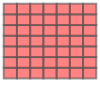

In [214]:
split_polygon = splitPolygon(roi_gdf,num_splitters)
split_polygon

In [236]:
# get iteractive access to polygons that makeup multipart geometry
# help(split_polygon.geoms)


In [243]:
type(list(part.exterior.coords)[0])

tuple

In [241]:
type(part.exterior.coords)

shapely.coords.CoordinateSequence

In [239]:
for part in split_polygon.geoms:
    print(list(part.exterior.coords))
    # print(part.exterior.coords)
    # print(part)

[(-124.286932, 40.667917), (-124.286932, 40.694368142857144), (-124.25417157142857, 40.694368142857144), (-124.25417157142857, 40.667917), (-124.286932, 40.667917)]
[(-124.25417157142857, 40.694368142857144), (-124.22141114285714, 40.694368142857144), (-124.22141114285714, 40.667917), (-124.25417157142857, 40.667917), (-124.25417157142857, 40.694368142857144)]
[(-124.22141114285714, 40.694368142857144), (-124.18865071428571, 40.694368142857144), (-124.18865071428571, 40.667917), (-124.22141114285714, 40.667917), (-124.22141114285714, 40.694368142857144)]
[(-124.18865071428571, 40.694368142857144), (-124.15589028571428, 40.694368142857144), (-124.15589028571428, 40.667917), (-124.18865071428571, 40.667917), (-124.18865071428571, 40.694368142857144)]
[(-124.15589028571428, 40.694368142857144), (-124.12312985714286, 40.694368142857144), (-124.12312985714286, 40.667917), (-124.15589028571428, 40.667917), (-124.15589028571428, 40.694368142857144)]
[(-124.12312985714286, 40.694368142857144),

In [218]:
sitename="doge_palace"
dir_path = os.path.abspath(sitename + os.sep + "feature" + str(1))
dir_path

'C:\\1_USGS\\5_Doodleverse\\1_Seg2Map_fork\\seg2map\\doge_palace\\feature1'

In [226]:
from typing import List
def create_time_series_dirs(sitename:str,years:List[int],num_features:int):
    for featurenumber in range(num_features):
        for year in years:
            dir_path = os.path.abspath(sitename + os.sep + "feature" + str(featurenumber))
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            sub_dir=os.path.join(dir_path,str(year))
            if not os.path.exists(sub_dir):
                os.makedirs(sub_dir)

In [228]:
sitename="doge_palace"
years = ["2006", "2009",]
num_features=2
create_time_series_dirs(sitename,years,num_features)

In [223]:
for i in range(num_features):
    print(i)

0
1


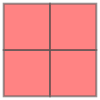

In [216]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
poly = Polygon([(0, 0), (0, 10), (10, 10), (10, 0)])
df = gpd.GeoDataFrame(geometry=[poly])
result = splitPolygon(df, 2)
result # polygon split into 4 equally sized tiles

In [19]:
list(coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="1"]["geometry"][0].exterior.coords)

[(-124.166621, 40.871052),
 (-124.166621, 40.894933),
 (-124.142247, 40.894933),
 (-124.142247, 40.871052),
 (-124.166621, 40.871052)]

In [21]:
coordinates=list(coastsegmap.rois.gdf[coastsegmap.rois.gdf["id"]=="1"]["geometry"][0].exterior.coords)
coordinates

[(-124.166621, 40.871052),
 (-124.166621, 40.894933),
 (-124.142247, 40.894933),
 (-124.142247, 40.871052),
 (-124.166621, 40.871052)]

In [24]:
coordinates=[list(x)for x in coordinates]

In [25]:
coordinates

[[-124.166621, 40.871052],
 [-124.166621, 40.894933],
 [-124.142247, 40.894933],
 [-124.142247, 40.871052],
 [-124.166621, 40.871052]]

In [ ]:
roi_geometry =

In [57]:
from area import area
area_km2=area(rect['features'][0]['geometry'])/ 1e6
area_km2
# 0.00887890515200013

83.05864238999565

In [112]:
import math
# get minimum number of horizontal and vertical splitters
num_splitters = math.ceil(math.sqrt(area_km2/10))
num_splitters

3

In [ ]:

minx, miny, maxx, maxy = polygon.bounds
minx, miny, maxx, maxy

In [ ]:
y=[1,2,3,4]
y

In [ ]:
y.remove(2)

In [ ]:
y

In [ ]:
x=set([1,2,3,4])
x

In [ ]:
len(x)

In [ ]:
x.remove(3)

In [ ]:
x

In [5]:
print(coastsegmap.map.find_layer('ROI'))

GeoJSON(data={'type': 'FeatureCollection', 'features': [{'id': '0', 'type': 'Feature', 'properties': {'id': '1', 'style': {'color': '#555555', 'fill_color': '#555555', 'fillOpacity': 0.1, 'weight': 1}}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-124.166621, 40.871052], [-124.166621, 40.894933], [-124.142247, 40.894933], [-124.142247, 40.871052], [-124.166621, 40.871052]]]}}, {'id': '1', 'type': 'Feature', 'properties': {'id': '2', 'style': {'color': '#555555', 'fill_color': '#555555', 'fillOpacity': 0.1, 'weight': 1}}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-124.164718, 40.951685], [-124.164718, 41.016997], [-124.028772, 41.016997], [-124.028772, 40.951685], [-124.164718, 40.951685]]]}}, {'id': '2', 'type': 'Feature', 'properties': {'id': '3', 'style': {'color': '#555555', 'fill_color': '#555555', 'fillOpacity': 0.1, 'weight': 1}}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-124.286932, 40.667917], [-124.286932, 40.853075], [-124.057609, 40.853075], [-124.0576

In [ ]:
def get_callback(marker, html):
    def callback(*args, **kwargs):
        html.value = '''
            <b>Glider Mission:</b><br>
            {}
        '''.format(marker.name)

    return callback

marker.on_mouseover(get_callback(marker, html))

In [ ]:
def delete_callback(layer,coastseg_map):
    def callback(*args, **kwargs):
        print("yesss")
        coastseg_map.accordion.children[0].value=""" 
        <p>Layer: {}</p>
        """.format(
            layer
        )
        layer.style=delete_style

    return callback

 # 'on_mouseout',
 # 'on_mouseover',
# marker.on_mouseover(get_callback(layer))

In [ ]:
def normal_callback(layer,coastseg_map):
    def callback(*args, **kwargs):
        print("yesss")
        coastseg_map.accordion.children[0].value=""" 
        <p>Layer: {}</p>
        """.format(
            layer
        )
        layer.style=normal_style

    return callback

In [ ]:
# dir(coastsegmap.map.find_layer('ROI'))

In [ ]:
layer = coastsegmap.map.find_layer('ROI')
# layer.on_hover(delete_callback(layer,coastsegmap))
layer.on_mouseover(delete_callback(layer,coastsegmap))
# layer.on_mouseout(normal_callback(layer,coastsegmap))
existing_layer = coastsegmap.map.find_layer('ROI')
if existing_layer is not None:
    coastsegmap.map.remove_layer(existing_layer)
coastsegmap.map.add_layer(layer)

In [ ]:
existing_layer = coastsegmap.map.find_layer('ROI')
if existing_layer is not None:
    coastsegmap.map.remove_layer(existing_layer)

In [ ]:
coastsegmap.map

In [ ]:
layer.on_hover

In [ ]:
delete_style = {'color': '#f73c02', 'fill_color': '#f73c02', 'fillOpacity': 0.1, 'weight': 1}
unselect_style = {'color': '#555555', 'fill_color': '#555555', 'fillOpacity': 0.1, 'weight': 1}
selected_style = {'color': '#ed2805', 'fill_color': '#ed2805', 'fillOpacity': 0.1, 'weight': 1}

In [ ]:
coastsegmap.map.find_layer('ROI').style=unselect_style

In [ ]:
# change layer to selected for deletion
layer = coastsegmap.map.find_layer('ROI')
layer.style=style={'color': '#ed2805', 'fill_color': '#ed2805', 'fillOpacity': 0.1, 'weight': 1}
coastsegmap.map.add_layer(layer)

In [ ]:
# deselect layer for deletion
layer = coastsegmap.map.find_layer('ROI')
layer.style=style={'color': '#555555', 'fill_color': '#555555', 'fillOpacity': 0.1, 'weight': 1}
coastsegmap.map.add_layer(layer)

In [ ]:
print(coastsegmap.rois)
print(coastsegmap.ids)

In [ ]:
new_id = "1" if coastsegmap.ids == [] else  str(int(max(coastsegmap.ids))+1)
new_id

In [ ]:
print(coastsegmap.rois.gdf)

In [ ]:
import geopandas as gpd

In [ ]:
filename = r"C:\1_USGS\CoastSeg\repos\2_CoastSeg\CoastSeg_fork\Seg2Map\rois.geojson"
with open(filename, "r") as f:
    gpd_data = gpd.read_file(f)

In [ ]:
gpd_data

In [ ]:
main = gpd_data[gpd_data["id"]!=id]
main

In [ ]:
id="13"
new_gdf = gpd_data[gpd_data["id"]==id]
new_gdf

In [ ]:
import pandas as pd
new_gdf = gpd.GeoDataFrame(
        pd.concat([main, new_gdf], ignore_index=True)
    )


In [ ]:
new_gdf

In [ ]:
class Feature:
    def __init__(self):
        self.gdf=""

In [ ]:
feature =  Feature()

In [ ]:
hasattr(feature,"gdf")

In [ ]:
type(gpd_data) == gpd.GeoDataFrame